Saaksshi Jilhewar - sjilhewa \
Gauri Dalwankar - gdalwank

In [1]:
#importing libraries

import tensorflow as tf
import pandas as pd
from tensorflow import keras 

import datetime
from tensorflow import metrics

import findspark
import pyspark
import pyspark.sql.functions as F
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [2]:
#creating spark session

findspark.init()
findspark.find()

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("MQTT") \
    .getOrCreate()

spark = SparkSession.builder.appName("mqttProject").getOrCreate()
sc    = spark.sparkContext

sqlContext = SQLContext(sc)

C:\Users\gauri\anaconda3\lib\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np
from matplotlib import pyplot as plt

col_names = ['tcp_flags',
 'tcp_time_delta',
 'tcp_len',
 'mqtt_conack_flags',
 'mqtt_conack_flags_reserved',
 'mqtt_conack_flags_sp',
 'mqtt_conack_val',
 'mqtt_conflag_cleansess',
 'mqtt_conflag_passwd',
 'mqtt_conflag_qos',
 'mqtt_conflag_reserved',
 'mqtt_conflag_retain',
 'mqtt_conflag_uname',
 'mqtt_conflag_willflag',
 'mqtt_conflags',
 'mqtt_dupflag',
 'mqtt_hdrflags',
 'mqtt_kalive',
 'mqtt_len',
 'mqtt_msg',
 'mqtt_msgid',
 'mqtt_msgtype',
 'mqtt_proto_len',
 'mqtt_qos',
 'mqtt_retain',
 'mqtt_sub_qos',
 'mqtt_suback_qos',
 'mqtt_ver',
 'mqtt_willmsg',
 'mqtt_willmsg_len',
 'mqtt_willtopic',
 'mqtt_willtopic_len',
 'target']

nominal_cols = ['tcp_flags',
 'mqtt_conack_flags',
 'mqtt_conflags',
 'mqtt_hdrflags',
 'mqtt_msg',
 'mqtt_protoname']

continuous_cols = ['tcp_time_delta',
 'tcp_len',
 'mqtt_conack_flags_reserved',
 'mqtt_conack_flags_sp',
 'mqtt_conack_val',
 'mqtt_conflag_cleansess',
 'mqtt_conflag_passwd',
 'mqtt_conflag_qos',
 'mqtt_conflag_reserved',
 'mqtt_conflag_retain',
 'mqtt_conflag_uname',
 'mqtt_conflag_willflag',
 'mqtt_dupflag',
 'mqtt_kalive',
 'mqtt_len',
 'mqtt_msgid',
 'mqtt_msgtype',
 'mqtt_proto_len',
 'mqtt_qos',
 'mqtt_retain',
 'mqtt_sub_qos',
 'mqtt_suback_qos',
 'mqtt_ver',
 'mqtt_willmsg',
 'mqtt_willmsg_len',
 'mqtt_willtopic',
 'mqtt_willtopic_len']

In [4]:
to_drop =  ["mqtt_conflag_cleansess","mqtt_proto_len","mqtt_conflag_passwd","mqtt_qos"]

In [5]:
# class OutcomeCreater_binary(Transformer): # this defines a transformer that creates the outcome column which tell if it's an attack or not
    
#     def __init__(self):
#         super().__init__()
  
#     def _transform(self, dataset):
#         label_to_binary = udf(lambda name: 0.0 if name == 'legitimate' else 1.0)
#         output_df = dataset.withColumn('outcome', label_to_binary(col('target'))).drop("target")  
#         output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
#         return output_df
    
class OutcomeCreater_multi(Transformer): # this defines a transformer that creates the outcome column ehich defines the type of attack
    
    def __init__(self):
        super().__init__()
  
    def _transform(self, dataset):
        label_to_multiple = udf(lambda name: 0.0 if name == 'legitimate' else (1.0 if name == "flood" else(2.0 if name == "dos" else(3.0 if name == "bruteforce" else(4.0 if name == "slowite" else (5.0))))))
        output_df = dataset.withColumn('outcome', label_to_multiple(col('target'))).drop("target")  
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        return output_df
        
class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
    
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
            
        return output_df
    
def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )
    
    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+nominal_onehot_cols
    corelated_cols_to_remove = to_drop
    
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    

    # Stage for creating the outcome column representing whether there is attack/type of attack
    stage_outcome = OutcomeCreater_multi()
#     stage_outcome = OutcomeCreater_binary()

    # Removing all unnecessary columns, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols + continuous_cols + ['vectorized_features'])
    
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    
    return pipeline 

In [6]:
train = spark.read.csv( (r"C:\Users\gauri\OneDrive\Desktop\mqtt project\data\train70_augmented.csv"),header=True, inferSchema= True)
test = spark.read.csv( (r"C:\Users\gauri\OneDrive\Desktop\mqtt project\data\test30_augmented.csv"),header=True, inferSchema= True)

train = train.toDF(*(c.replace('.', '_') for c in train.columns))
test = test.toDF(*(c.replace('.', '_') for c in test.columns))

In [7]:
preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(train)

train_df = preprocess_pipeline_model.transform(train)
test_df = preprocess_pipeline_model.transform(test)

In [8]:
train_df.printSchema()
test_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)



In [9]:
train_df.show(10)

+--------------------+-------+
|            features|outcome|
+--------------------+-------+
|(50369,[0,1,12,14...|    0.0|
|(50369,[0,27,30,3...|    3.0|
|(50369,[0,24,30,3...|    1.0|
|(50369,[0,24,30,3...|    4.0|
|(50369,[0,1,12,14...|    1.0|
|(50369,[0,1,12,14...|    0.0|
|(50369,[0,1,12,14...|    0.0|
|(50369,[0,24,30,3...|    3.0|
|(50369,[0,1,12,14...|    0.0|
|(50369,[0,1,8,11,...|    3.0|
+--------------------+-------+
only showing top 10 rows



In [10]:
test_df.show(10)

+--------------------+-------+
|            features|outcome|
+--------------------+-------+
|(50369,[1,10,12,1...|    2.0|
|(50369,[0,24,30,3...|    0.0|
|(50369,[0,24,30,3...|    4.0|
|(50369,[0,24,30,3...|    1.0|
|(50369,[0,1,12,14...|    4.0|
|(50369,[0,24,30,3...|    1.0|
|(50369,[0,1,14,23...|    0.0|
|(50369,[0,1,12,14...|    0.0|
|(50369,[0,24,30,3...|    0.0|
|(50369,[0,27,30,3...|    3.0|
+--------------------+-------+
only showing top 10 rows



In [19]:
train_df = train_df.limit(1400)
test_df = test_df.limit(600)

In [20]:
to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

df_train = train_df 
df_validate,df_test = test_df.randomSplit([0.5,0.5])

df_train_pandas = df_train.withColumn('features', to_array('features')).toPandas()

In [21]:
df_validate_pandas = df_validate.withColumn('features', to_array('features')).toPandas()


In [22]:
df_test_pandas = df_test.withColumn('features', to_array('features')).toPandas()

In [23]:
x_train = tf.constant(np.array(df_train_pandas['features'].values.tolist()))
y_train = tf.constant(np.array(df_train_pandas['outcome'].values.tolist()))

x_validate = tf.constant(np.array(df_validate_pandas['features'].values.tolist()))
y_validate = tf.constant(np.array(df_validate_pandas['outcome'].values.tolist()))


x_test = tf.constant(np.array(df_test_pandas['features'].values.tolist()))
y_test = tf.constant(np.array(df_test_pandas['outcome'].values.tolist()))

In [24]:
x_cv = tf.concat([x_train,x_validate],axis=0)
y_cv = tf.concat([y_train,y_validate],axis=0)

# Deep Neural Networks

In [30]:
#defining dataset for cross-validation

def prepare_kfold_data(x_cv,y_cv,k):
    data_cv = tf.concat([x_cv,tf.expand_dims(y_cv,1)],axis = 1)
    data_cv = tf.random.shuffle(data_cv)
    N_samples = x_cv.shape[0]
    N_subset = N_samples //k
    return_subsets = []

    for i in range(k):
        validation_i = tf.identity(data_cv[i*N_subset:(i+1)*N_subset,:])
        train_i_index = []
        if i > 0:
            train_i_index = train_i_index + list(range(0,i*N_subset))
        if i<k-1:
            train_i_index = train_i_index + list(range((i+1)*N_subset,N_samples))
        train_i = tf.identity(tf.gather(data_cv,train_i_index,axis = 0 ))

        return_subsets.append( (train_i[:,:-2],train_i[:,-1],validation_i[:,:-2],validation_i[:,-1]) )
    
    return return_subsets

In [31]:
k_fold_datasets = prepare_kfold_data(x_cv,y_cv,2)

In [32]:
from tensorboard.plugins.hparams import api as hp

HP_WIDTH = hp.HParam('NN_width', hp.Discrete([20,30,40]))
HP_DEPTH = hp.HParam('NN_depth', hp.Discrete([4,6,8]))


with tf.summary.create_file_writer('Gauri/test').as_default():
  hp.hparams_config(
    hparams=[HP_WIDTH, HP_DEPTH],
    metrics=[hp.Metric('Accuracy')],
  )


In [33]:
def train_test_model(hparams,logdir,k_fold_datasets):
  k = len(k_fold_datasets)
  accuracy = 0.0
  for i in range(k):
    model = keras.Sequential()
    for _ in range(hparams[HP_DEPTH]):
      model.add(keras.layers.Dense(hparams[HP_WIDTH],activation='relu'))
    model.add(keras.layers.Dense(6))
    
    model.compile(
        optimizer=keras.optimizers.SGD(),
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="Accuracy_epochs")])

    history = model.fit(k_fold_datasets[i][0], k_fold_datasets[i][1], epochs=20, verbose = 2,
    validation_data = (k_fold_datasets[i][2], k_fold_datasets[i][3]))

    accuracy += np.max(history.history["val_Accuracy_epochs"])

  return accuracy/k


In [34]:
for hp_width in HP_WIDTH.domain.values:
  for hp_depth in (HP_DEPTH.domain.values):
    hparams = {
        HP_WIDTH: hp_width,
        HP_DEPTH: hp_depth,
    }
    run_name = f"run-WIDTH{int(hparams[HP_WIDTH])}-DEPTH{hparams[HP_DEPTH]}"
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})

    run_dir = 'Gauri/test/' + run_name
    accuracy = train_test_model(hparams,run_dir,k_fold_datasets)
    
    with tf.summary.create_file_writer(run_dir).as_default():
      hp.hparams(hparams)  # record the values used in this trial
      tf.summary.scalar("Accuracy", accuracy, step=1)

    

--- Starting trial: run-WIDTH20-DEPTH4
{'NN_width': 20, 'NN_depth': 4}
Epoch 1/20
27/27 - 3s - loss: 1.6712 - Accuracy_epochs: 0.4183 - val_loss: 1.6330 - val_Accuracy_epochs: 0.4812 - 3s/epoch - 105ms/step
Epoch 2/20
27/27 - 1s - loss: 1.6028 - Accuracy_epochs: 0.4900 - val_loss: 1.5131 - val_Accuracy_epochs: 0.4988 - 744ms/epoch - 28ms/step
Epoch 3/20
27/27 - 1s - loss: 1.4788 - Accuracy_epochs: 0.5159 - val_loss: 1.4102 - val_Accuracy_epochs: 0.5306 - 560ms/epoch - 21ms/step
Epoch 4/20
27/27 - 1s - loss: 1.3689 - Accuracy_epochs: 0.5182 - val_loss: 1.3448 - val_Accuracy_epochs: 0.5329 - 606ms/epoch - 22ms/step
Epoch 5/20
27/27 - 1s - loss: 1.3025 - Accuracy_epochs: 0.5194 - val_loss: 1.3006 - val_Accuracy_epochs: 0.5329 - 630ms/epoch - 23ms/step
Epoch 6/20
27/27 - 1s - loss: 1.2431 - Accuracy_epochs: 0.5194 - val_loss: 1.2490 - val_Accuracy_epochs: 0.5294 - 590ms/epoch - 22ms/step
Epoch 7/20
27/27 - 1s - loss: 1.1962 - Accuracy_epochs: 0.5194 - val_loss: 1.2113 - val_Accuracy_epochs

In [35]:
%load_ext tensorboard
%tensorboard --logdir Gauri/test/ --port 8004

Reusing TensorBoard on port 8004 (pid 23508), started 6:18:45 ago. (Use '!kill 23508' to kill it.)

From TensorBoard we can see our best hyper-parameter which gave high accuracy, we can use these for prediction for test.
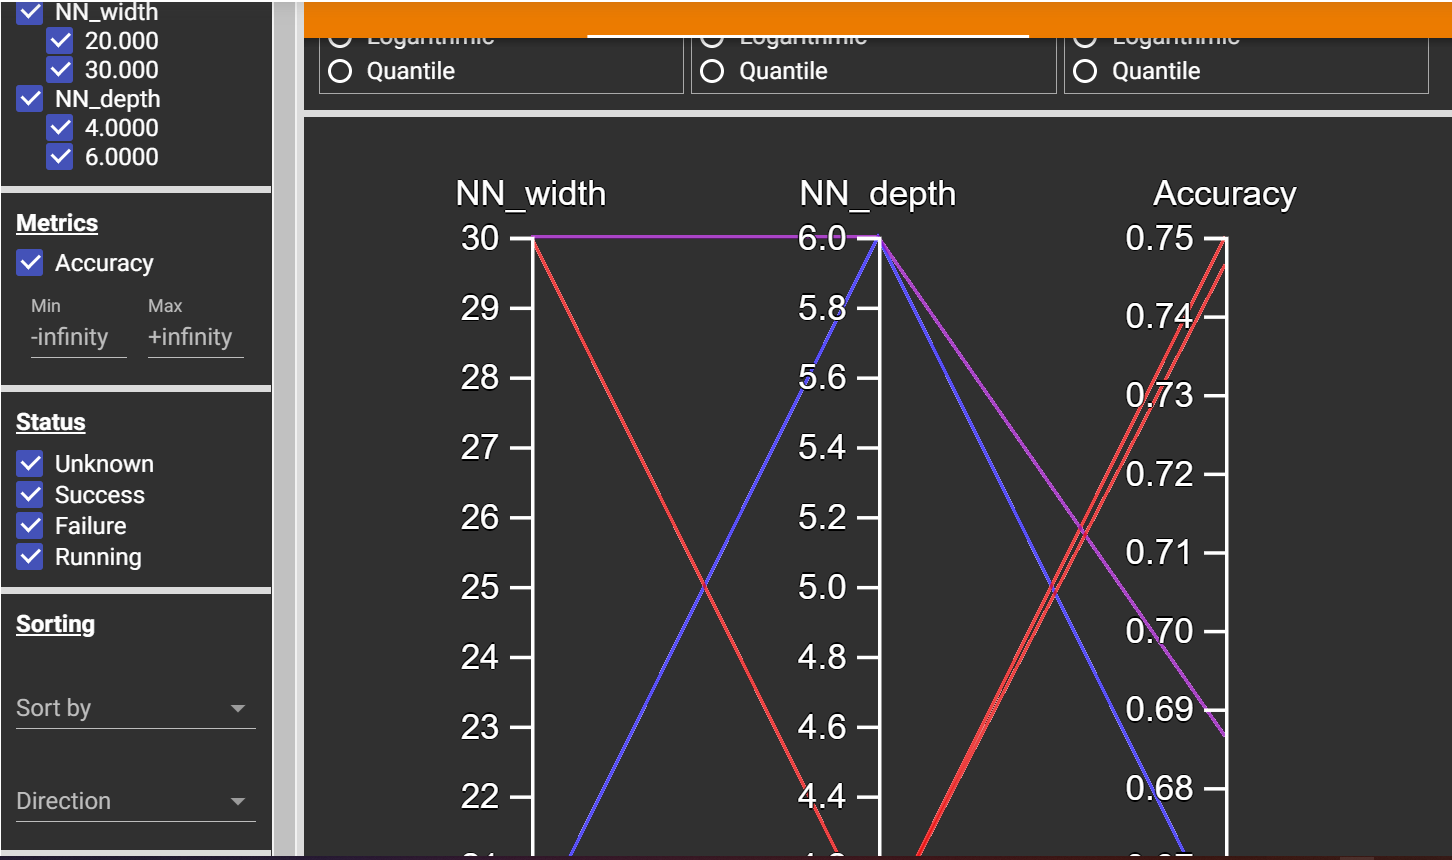

In [43]:
model = keras.Sequential()

def test_model(x_train,y_train,x_test,y_test):
  
    for _ in range(4):
        
        model.add(keras.layers.Dense(30,activation="relu"))
    model.add(keras.layers.Dense(6))
    
    model.compile(
        optimizer=keras.optimizers.SGD(),
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="Accuracy_epochs")])

    model.fit(x_train, y_train, epochs=20)
    
    acc_test=model.evaluate(x_test,y_test)
    
    return acc_test

In [44]:
accuracy = test_model(x_train,y_train,x_test,y_test)

Epoch 1/20
44/44 [==============================] - 4s 24ms/step - loss: 1.6949 - Accuracy_epochs: 0.4471
Epoch 2/20
44/44 [==============================] - 1s 21ms/step - loss: 1.4280 - Accuracy_epochs: 0.5129
Epoch 3/20
44/44 [==============================] - 1s 18ms/step - loss: 1.2701 - Accuracy_epochs: 0.5271
Epoch 4/20
44/44 [==============================] - 1s 28ms/step - loss: 1.1558 - Accuracy_epochs: 0.5386
Epoch 5/20
44/44 [==============================] - 1s 21ms/step - loss: 1.0559 - Accuracy_epochs: 0.6336
Epoch 6/20
44/44 [==============================] - 1s 21ms/step - loss: 0.9741 - Accuracy_epochs: 0.7014
Epoch 7/20
44/44 [==============================] - 1s 19ms/step - loss: 0.9054 - Accuracy_epochs: 0.7550
Epoch 8/20
44/44 [==============================] - 1s 22ms/step - loss: 0.8464 - Accuracy_epochs: 0.7721
Epoch 9/20
44/44 [==============================] - 1s 19ms/step - loss: 0.7923 - Accuracy_epochs: 0.7864
Epoch 10/20
44/44 [===========================

In [45]:
print("accuracy of the test dataset in %: ",accuracy[1]*100)

accuracy of the test dataset in %:  76.92307829856873


# Shallow Neural Networks

In [49]:
from tensorboard.plugins.hparams import api as hp

HP_WIDTH = hp.HParam('NN_width', hp.Discrete([20,30]))
HP_DEPTH = hp.HParam('NN_depth', hp.Discrete([1,2]))


with tf.summary.create_file_writer('Gauri/test1').as_default():
  hp.hparams_config(
    hparams=[HP_WIDTH, HP_DEPTH],
    metrics=[hp.Metric('Accuracy')],
  )


In [50]:
for hp_width in HP_WIDTH.domain.values:
  for hp_depth in (HP_DEPTH.domain.values):
    hparams = {
        HP_WIDTH: hp_width,
        HP_DEPTH: hp_depth,
    }
    run_name = f"run-WIDTH{int(hparams[HP_WIDTH])}-DEPTH{hparams[HP_DEPTH]}"
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})

    run_dir = 'Gauri/test1/' + run_name
    accuracy = train_test_model(hparams,run_dir,k_fold_datasets)
    
    with tf.summary.create_file_writer(run_dir).as_default():
      hp.hparams(hparams)  # record the values used in this trial
      tf.summary.scalar("Accuracy", accuracy, step=1)

    

--- Starting trial: run-WIDTH20-DEPTH1
{'NN_width': 20, 'NN_depth': 1}
Epoch 1/20
27/27 - 2s - loss: 1.9134 - Accuracy_epochs: 0.4383 - val_loss: 1.6324 - val_Accuracy_epochs: 0.5012 - 2s/epoch - 75ms/step
Epoch 2/20
27/27 - 1s - loss: 1.6686 - Accuracy_epochs: 0.5241 - val_loss: 1.3955 - val_Accuracy_epochs: 0.5506 - 877ms/epoch - 32ms/step
Epoch 3/20
27/27 - 1s - loss: 1.1082 - Accuracy_epochs: 0.6005 - val_loss: 1.2607 - val_Accuracy_epochs: 0.6165 - 894ms/epoch - 33ms/step
Epoch 4/20
27/27 - 1s - loss: 0.9308 - Accuracy_epochs: 0.6722 - val_loss: 1.1712 - val_Accuracy_epochs: 0.6882 - 793ms/epoch - 29ms/step
Epoch 5/20
27/27 - 1s - loss: 0.8381 - Accuracy_epochs: 0.7615 - val_loss: 1.1058 - val_Accuracy_epochs: 0.7494 - 975ms/epoch - 36ms/step
Epoch 6/20
27/27 - 1s - loss: 0.7714 - Accuracy_epochs: 0.7991 - val_loss: 1.0622 - val_Accuracy_epochs: 0.7588 - 802ms/epoch - 30ms/step
Epoch 7/20
27/27 - 1s - loss: 0.7188 - Accuracy_epochs: 0.8096 - val_loss: 1.0259 - val_Accuracy_epochs:

In [52]:
%load_ext tensorboard
%tensorboard --logdir Gauri/test1/ --port 8017

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


From TensorBoard we can see our best hyper-parameter which gave high accuracy, we can use these for prediction for test.
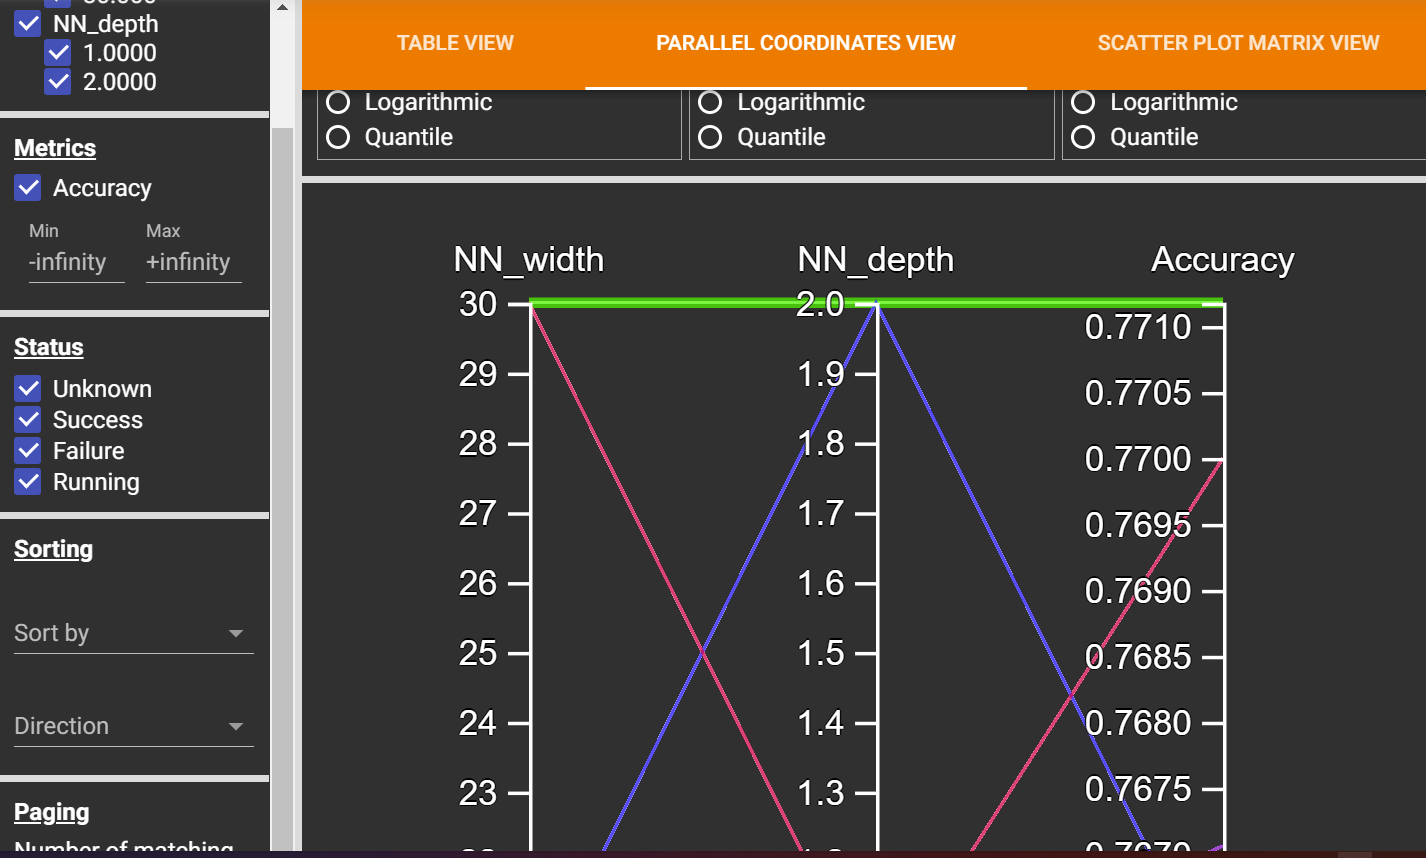

In [53]:
model = keras.Sequential()

def test_model(x_train,y_train,x_test,y_test):
  
    for _ in range(2):
        
        model.add(keras.layers.Dense(30,activation="relu"))
    model.add(keras.layers.Dense(6))
    
    model.compile(
        optimizer=keras.optimizers.SGD(),
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="Accuracy_epochs")])

    model.fit(x_train, y_train, epochs=20)
    
    acc_test=model.evaluate(x_test,y_test)
    
    return acc_test

In [54]:
accuracy = test_model(x_train,y_train,x_test,y_test)

Epoch 1/20
44/44 [==============================] - 3s 43ms/step - loss: 1.6536 - Accuracy_epochs: 0.4671
Epoch 2/20
44/44 [==============================] - 1s 17ms/step - loss: 1.3059 - Accuracy_epochs: 0.5336
Epoch 3/20
44/44 [==============================] - 1s 16ms/step - loss: 1.1372 - Accuracy_epochs: 0.5671
Epoch 4/20
44/44 [==============================] - 1s 18ms/step - loss: 1.0157 - Accuracy_epochs: 0.6486
Epoch 5/20
44/44 [==============================] - 1s 19ms/step - loss: 0.9212 - Accuracy_epochs: 0.7036
Epoch 6/20
44/44 [==============================] - 1s 19ms/step - loss: 0.8301 - Accuracy_epochs: 0.7436
Epoch 7/20
44/44 [==============================] - 1s 19ms/step - loss: 0.7508 - Accuracy_epochs: 0.7807
Epoch 8/20
44/44 [==============================] - 1s 33ms/step - loss: 0.6899 - Accuracy_epochs: 0.8136
Epoch 9/20
44/44 [==============================] - 1s 20ms/step - loss: 0.6467 - Accuracy_epochs: 0.8250
Epoch 10/20
44/44 [===========================

In [55]:
print("accuracy of the test dataset in %: ",accuracy[1]*100)

accuracy of the test dataset in %:  73.24414849281311
